In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

JAK_INHIBITORS = False

data_dir = "../data/08222025_IF_scan"
if_data_files = ["Cell.csv"]

columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]

column_to_stain = dict(zip(range(1,13), ["pSTAT"]*6 + ["tSTAT"] * 6))
column_to_stain = dict(zip(range(1,13), ["pSTAT"]*12))
column_to_stain = dict(zip(range(1,13), ["Fedra"]*6 + ["Filgo"]*6))

row_to_patient = {
    "A":626,
	"B":813,
	"C":813,
	"D":617,
	"E":617,
	"F":617,
	#"G":617,
	#"H":617
}	

column_to_t_pts = {
	1:"0",
    2:"0",
	3:"0.33",
	4:"1",
	5:"3.33",
	6:"10",
	7:"0",
    8:"0",
	9:"0.33",
	10:"1",
	11:"3.33",
	12:"10"
}

row_to_replicate = {
    "A":1,
    "B":1,
    "C":2,
    "D":1,
    "E":2,
    "F":3,
    #"G":2,
    #"H":1    
}
if JAK_INHIBITORS:
	drug_to_row = {
		"B":"Control",
		"C":np.nan,
		"D":"Control",
		"E":"1nM Fedratinib",
		"F":"10nM Fedratinib",
		"G":"1nM Filgotinib",
		"H":"10nM Filgotinib"
	}


In [18]:
dfs = []
for fname in if_data_files:
	full_fname = f"{data_dir}/{fname}"
	df = pd.read_csv(full_fname, usecols=columns)

	stat1_means = df.groupby("WellId")["CircTotalIntenCh2"].mean()
	stat1_sems = df.groupby("WellId")["CircTotalIntenCh2"].std()
	stat3_means = df.groupby("WellId")["CircTotalIntenCh3"].mean()
	stat3_sems = df.groupby("WellId")["CircTotalIntenCh3"].std()

	stat_df = pd.concat([stat1_means, stat1_sems, stat3_means, stat3_sems], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 SEM", "STAT3 Mean", "STAT3 SEM"]
	stat_df.index = [x.strip() for x in stat_df.index]
	# Assign various characteristics based on wells using the dictionaries above
	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [column_to_stain[x] for x in cols]
	stat_df["PatientId"] = [row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [column_to_t_pts[x] for x in cols]
	stat_df["Replicate"] = [row_to_replicate[x] for x in rows]
	if JAK_INHIBITORS:
		stat_df["JAK Inhibitor"] = [drug_to_row[x] for x in rows]
		stat_df["Column"] = cols
		stat_df.loc[[f"C0{i}" for i in [3,4,5,6]], "JAK Inhibitor"] = "1nM Fedratinib"
		stat_df.loc[[f"C{i:02d}" for i in [7,8,9,10]], "JAK Inhibitor"] = "10nM Fedratinib"
	stat_df["Date"] = data_dir.split("/")[-1]
	display(stat_df)
	stat_df.to_csv(f"{data_dir.split('/')[-1]}.csv")
	dfs.append(stat_df)

,STAT1 Mean,STAT1 SEM,STAT3 Mean,STAT3 SEM,STAT,PatientId,IL-6 Concentration,Time,Replicate,Date
A01,4.587715e+06,2.791685e+06,5.333936e+06,4.051188e+06,Fedra,626,10 ng/mL,0,1,08222025_IF_scan
A02,6.657864e+06,4.791247e+06,9.501114e+06,6.817559e+06,Fedra,626,10 ng/mL,0,1,08222025_IF_scan
A03,2.732730e+06,7.230510e+05,1.797249e+06,9.472283e+05,Fedra,626,10 ng/mL,0.33,1,08222025_IF_scan
A04,2.748364e+06,7.466521e+05,1.416017e+06,5.238792e+05,Fedra,626,10 ng/mL,1,1,08222025_IF_scan
A05,3.029303e+06,8.213333e+05,1.432846e+06,4.067809e+05,Fedra,626,10 ng/mL,3.33,1,08222025_IF_scan
...,...,...,...,...,...,...,...,...,...,...
F08,4.506925e+06,2.736249e+06,6.661969e+06,5.010287e+06,Filgo,617,10 ng/mL,0,3,08222025_IF_scan
F09,3.643351e+06,1.591767e+06,5.501740e+06,4.186864e+06,Filgo,617,10 ng/mL,0.33,3,08222025_IF_scan
F10,3.392385e+06,1.285746e+06,4.139061e+06,2.826614e+06,Filgo,617,10 ng/mL,1,3,08222025_IF_scan
F11,2.700684e+06,8.887419e+05,1.250817e+06,4.475311e+05,Filgo,617,10 ng/mL,3.33,3,08222025_IF_scan


In [3]:
if JAK_INHIBITORS:
	ms = 8 # markersize
	color = "#606060"

	fig1, axs = plt.subplots(3,2, figsize=(17,18), dpi=300)

	stat1_ax = axs[0][0]
	stat3_ax = axs[0][1]


	df = stat_df[stat_df["PatientId"] == 626]

	temp = df[df["JAK Inhibitor"] == "Control"]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)

	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)

	drug = "1nM Fedratinib"
	color = "#55EAF5"
	temp = df[df["JAK Inhibitor"] == drug]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)

	drug = "10nM Fedratinib"
	color = "#3367D6"
	temp = df[df["JAK Inhibitor"] == drug]

	# Plot control
	temp_rep1 = temp[temp["Column"] >= 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)

	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Dosage")
	stat1_ax.set_title("Donor 626")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Dosage")
	stat3_ax.set_title("Donor 626")

	######################################################
	### DONOR 617 
	stat1_ax = axs[1][0]
	stat3_ax = axs[1][1]

	df = stat_df[stat_df["PatientId"] == 617]
	color = "#606060"
	temp = df[df["JAK Inhibitor"] == "Control"]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)

	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)

	drug = "1nM Fedratinib"
	color = "#55EAF5"
	temp = df[df["JAK Inhibitor"] == drug]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"{drug} (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"{drug} (Rep 2)", capsize=2)

	drug = "10nM Fedratinib"
	color = "#3367D6"
	temp = df[df["JAK Inhibitor"] == drug]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="-", label=f"{drug} (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="-", label=f"{drug} (Rep 2)", capsize=2)

	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Dosage")
	stat1_ax.set_title("Donor 617")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Dosage")
	stat3_ax.set_title("Donor 617")


	stat1_ax = axs[2][0]
	stat3_ax = axs[2][1]

	df = stat_df[stat_df["PatientId"] == 617]
	color = "#606060"
	temp = df[df["JAK Inhibitor"] == "Control"]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"Control (Rep 1)", capsize=2)

	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker="^", ms=ms, color=color,
				ls="--", label=f"Control (Rep 2)", capsize=2)

	drug = "1nM Filgotinib"
	color = "#FD73AC"
	temp = df[df["JAK Inhibitor"] == drug]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="--", label=f"{drug} (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="-", label=f"{drug} (Rep 2)", capsize=2)

	drug = "10nM Filgotinib"
	color = "#750000"
	temp = df[df["JAK Inhibitor"] == drug]
	# Plot control
	temp_rep1 = temp[temp["Column"] < 7]
	stat1_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT1 Mean"], yerr=temp_rep1["STAT1 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	stat3_ax.errorbar(x=temp_rep1["Time"], y=temp_rep1["STAT3 Mean"], yerr=temp_rep1["STAT3 SEM"],
				marker="x", ms=ms, color=color,
				ls="-", label=f"{drug}", capsize=2)
	temp_rep2 = temp[temp["Column"] > 6]
	stat1_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT1 Mean"], yerr=temp_rep2["STAT1 SEM"],
				marker=".", ms=ms, color=color,
				ls="-", label=f"{drug} (Rep 2)", capsize=2)
	stat3_ax.errorbar(x=temp_rep2["Time"], y=temp_rep2["STAT3 Mean"], yerr=temp_rep2["STAT3 SEM"],
				marker=".", ms=ms, color=color,
				ls="-", label=f"{drug} (Rep 2)", capsize=2)

	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Dosage")
	stat1_ax.set_title("Donor 617")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Dosage")
	stat3_ax.set_title("Donor 617")


Text(0.5, 0.98, 'Patient 617')

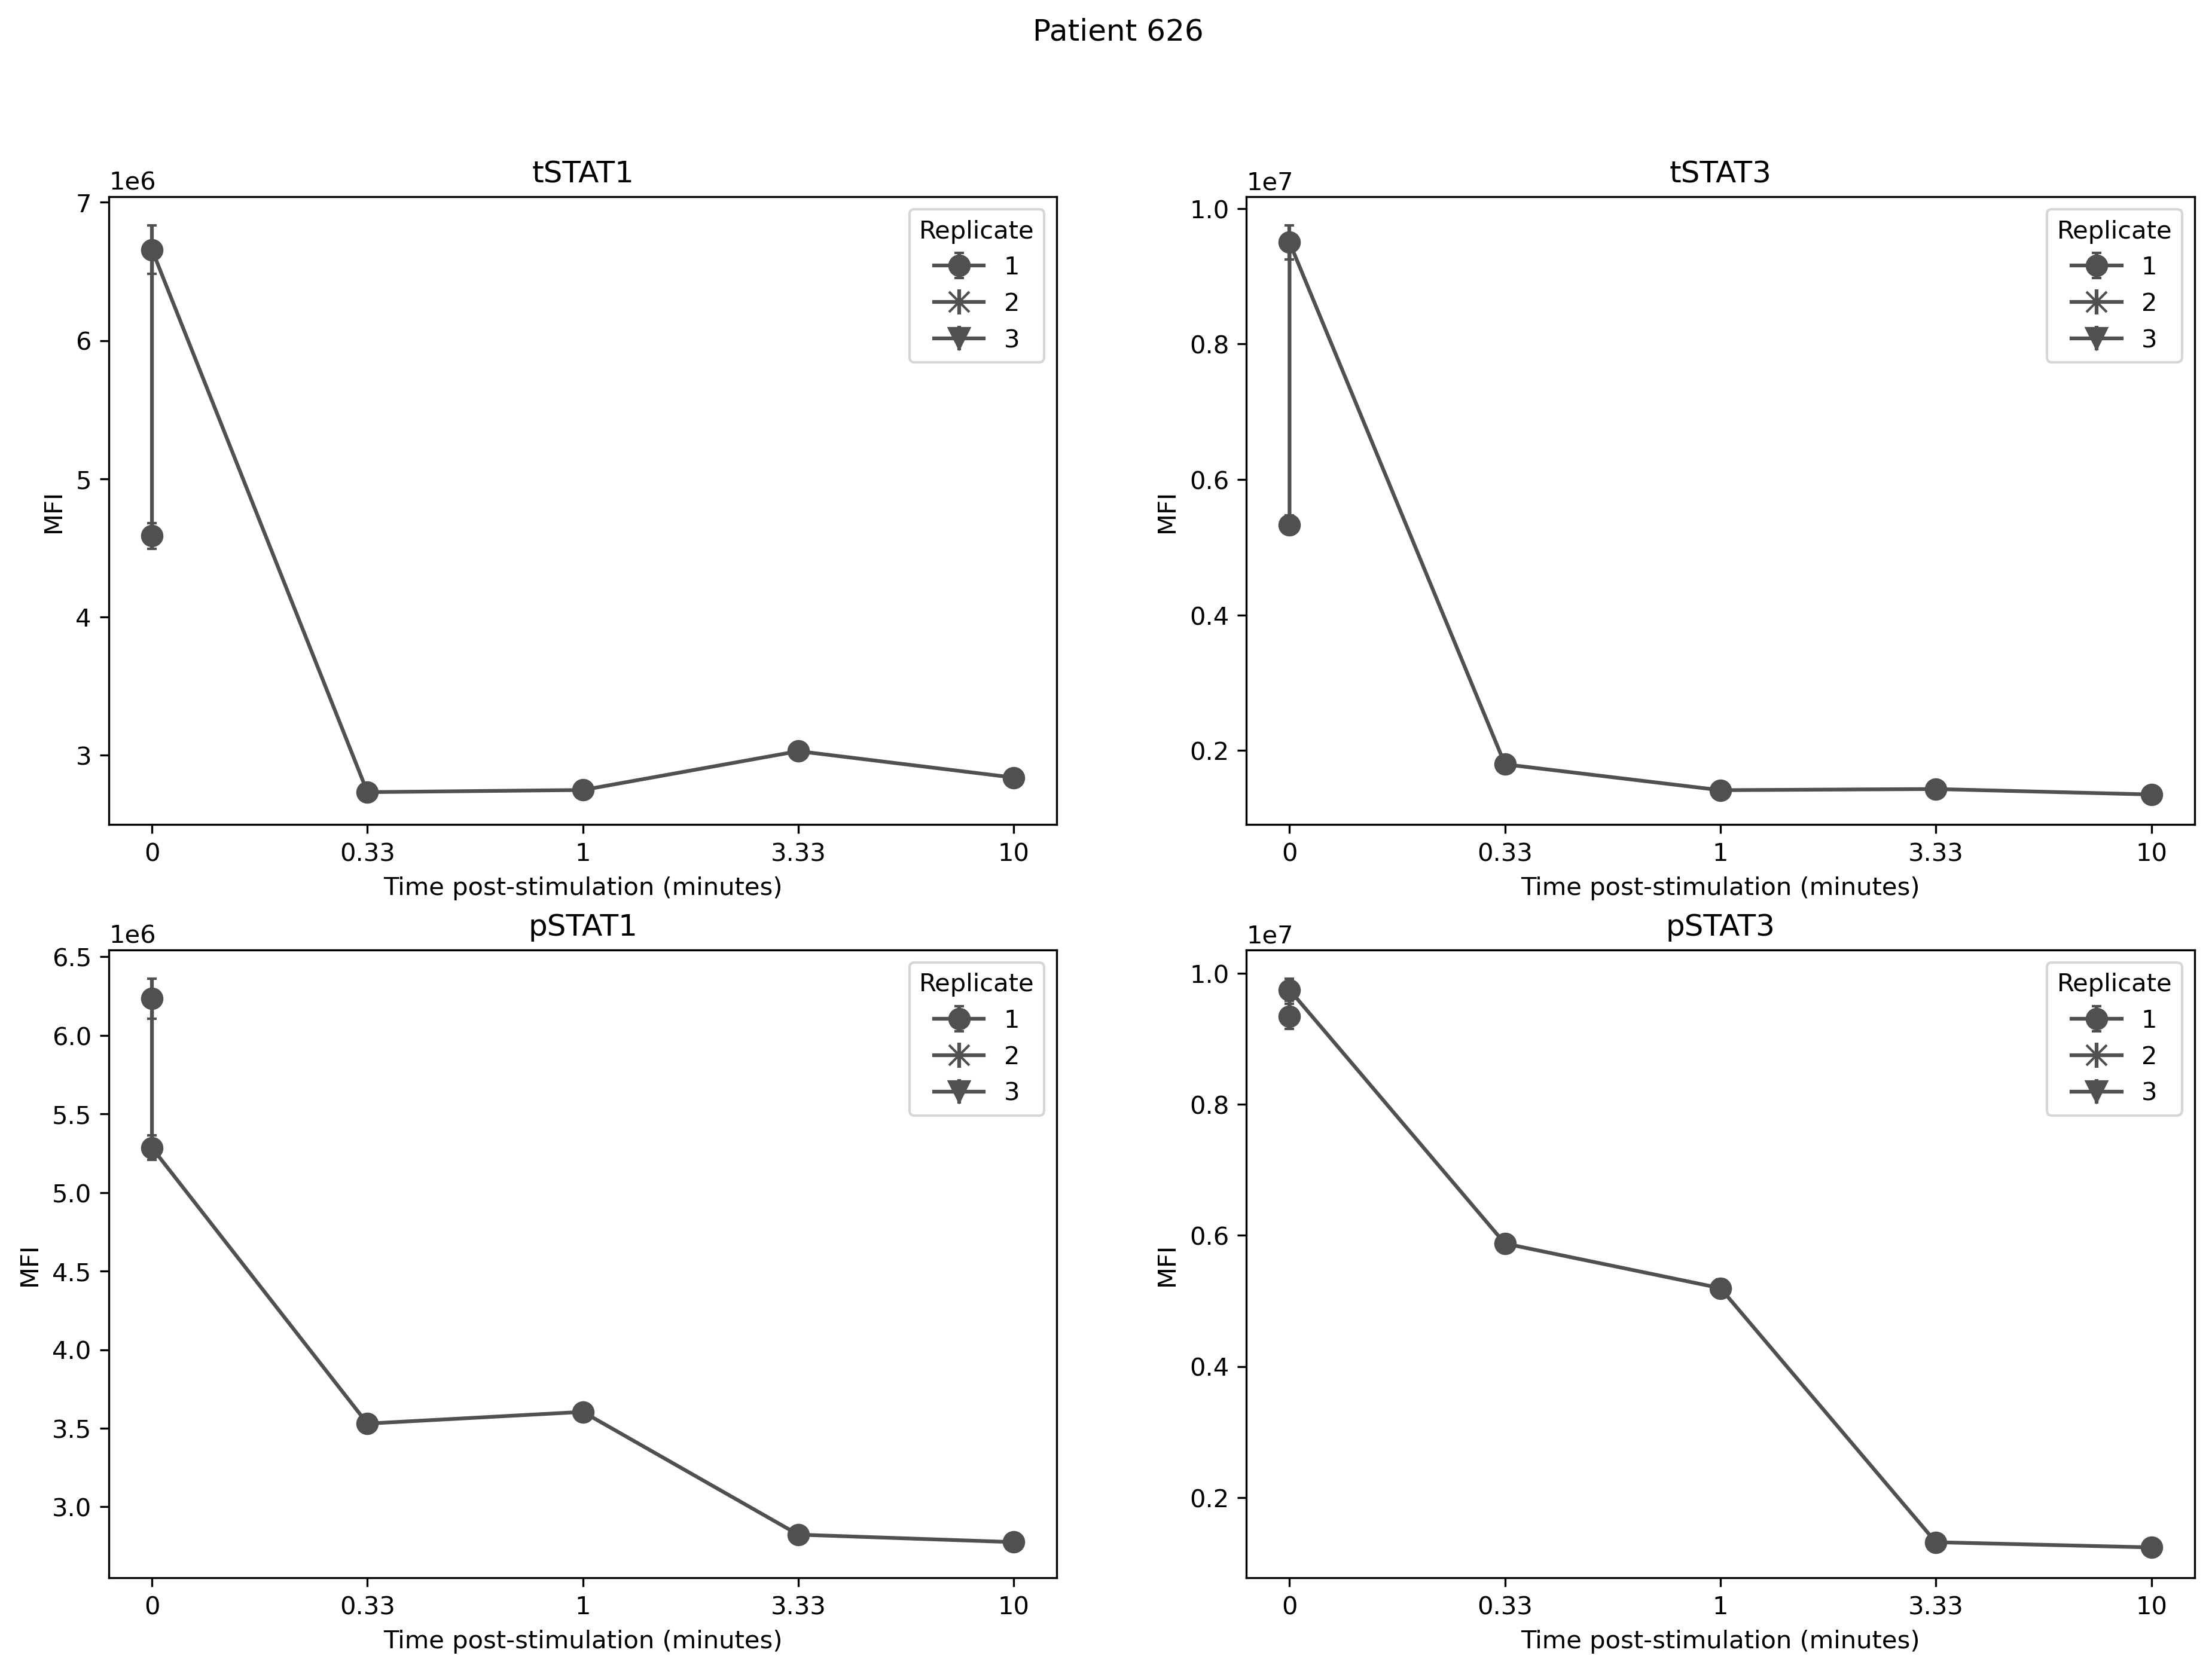

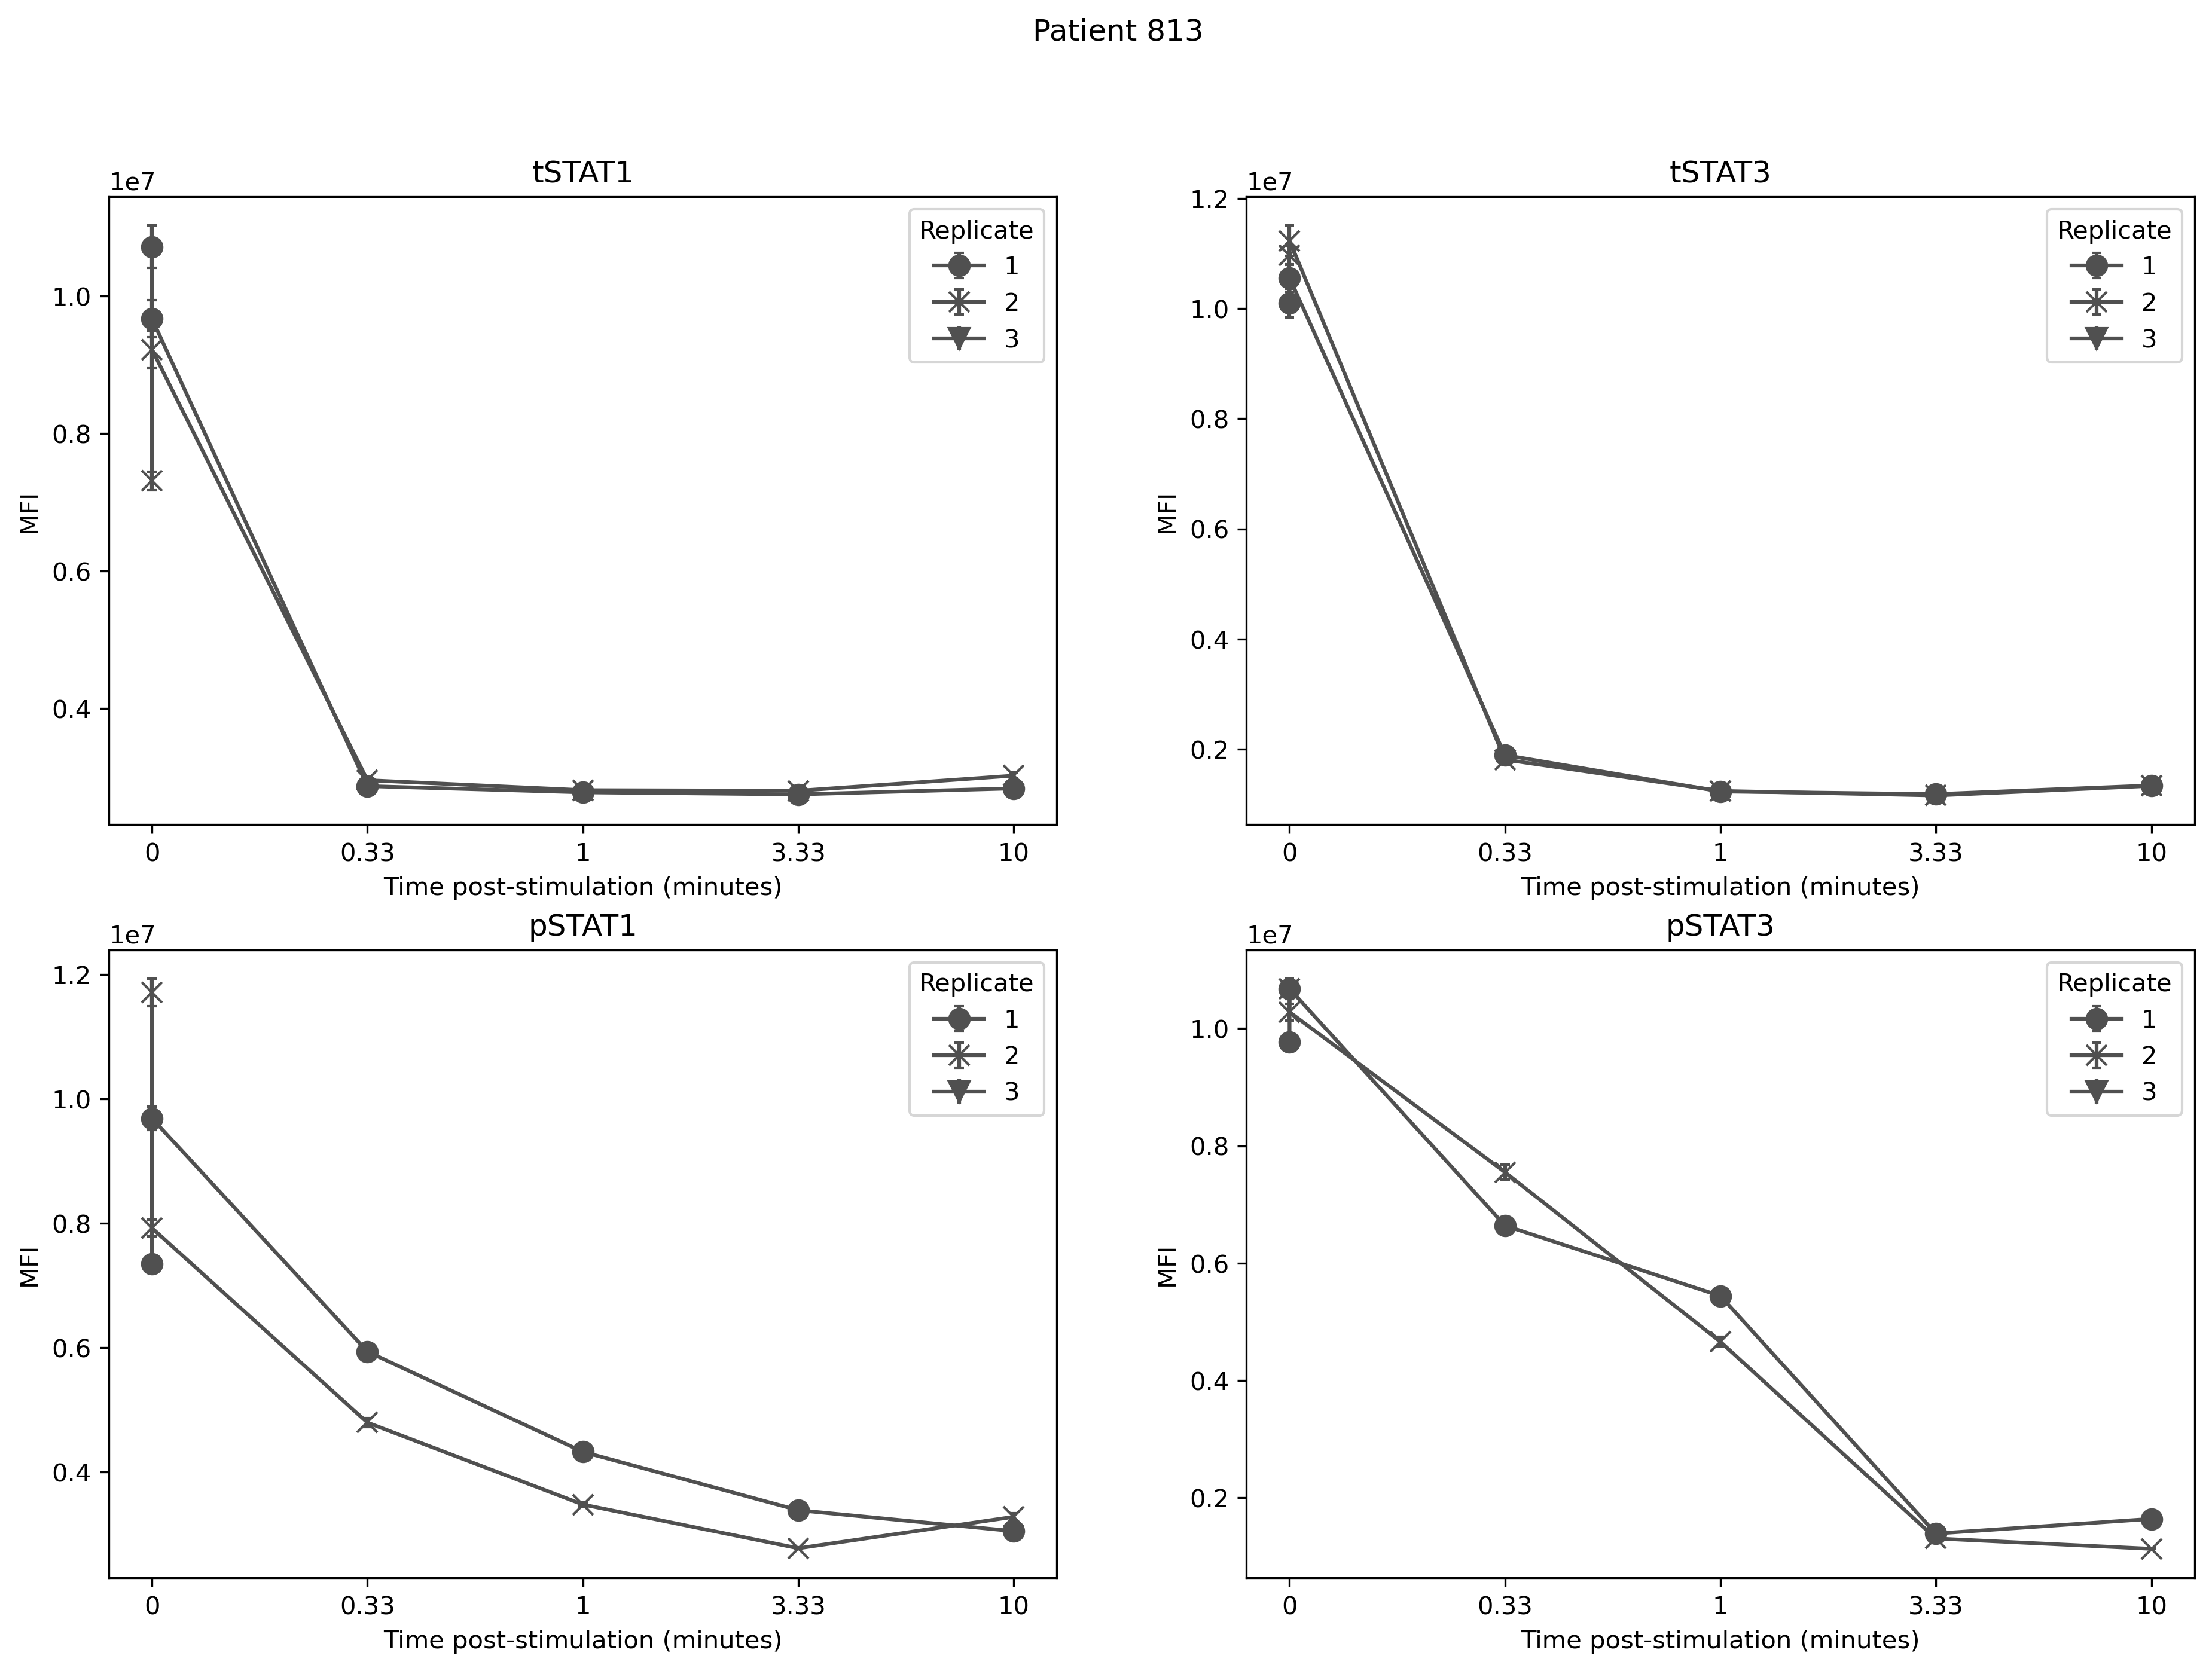

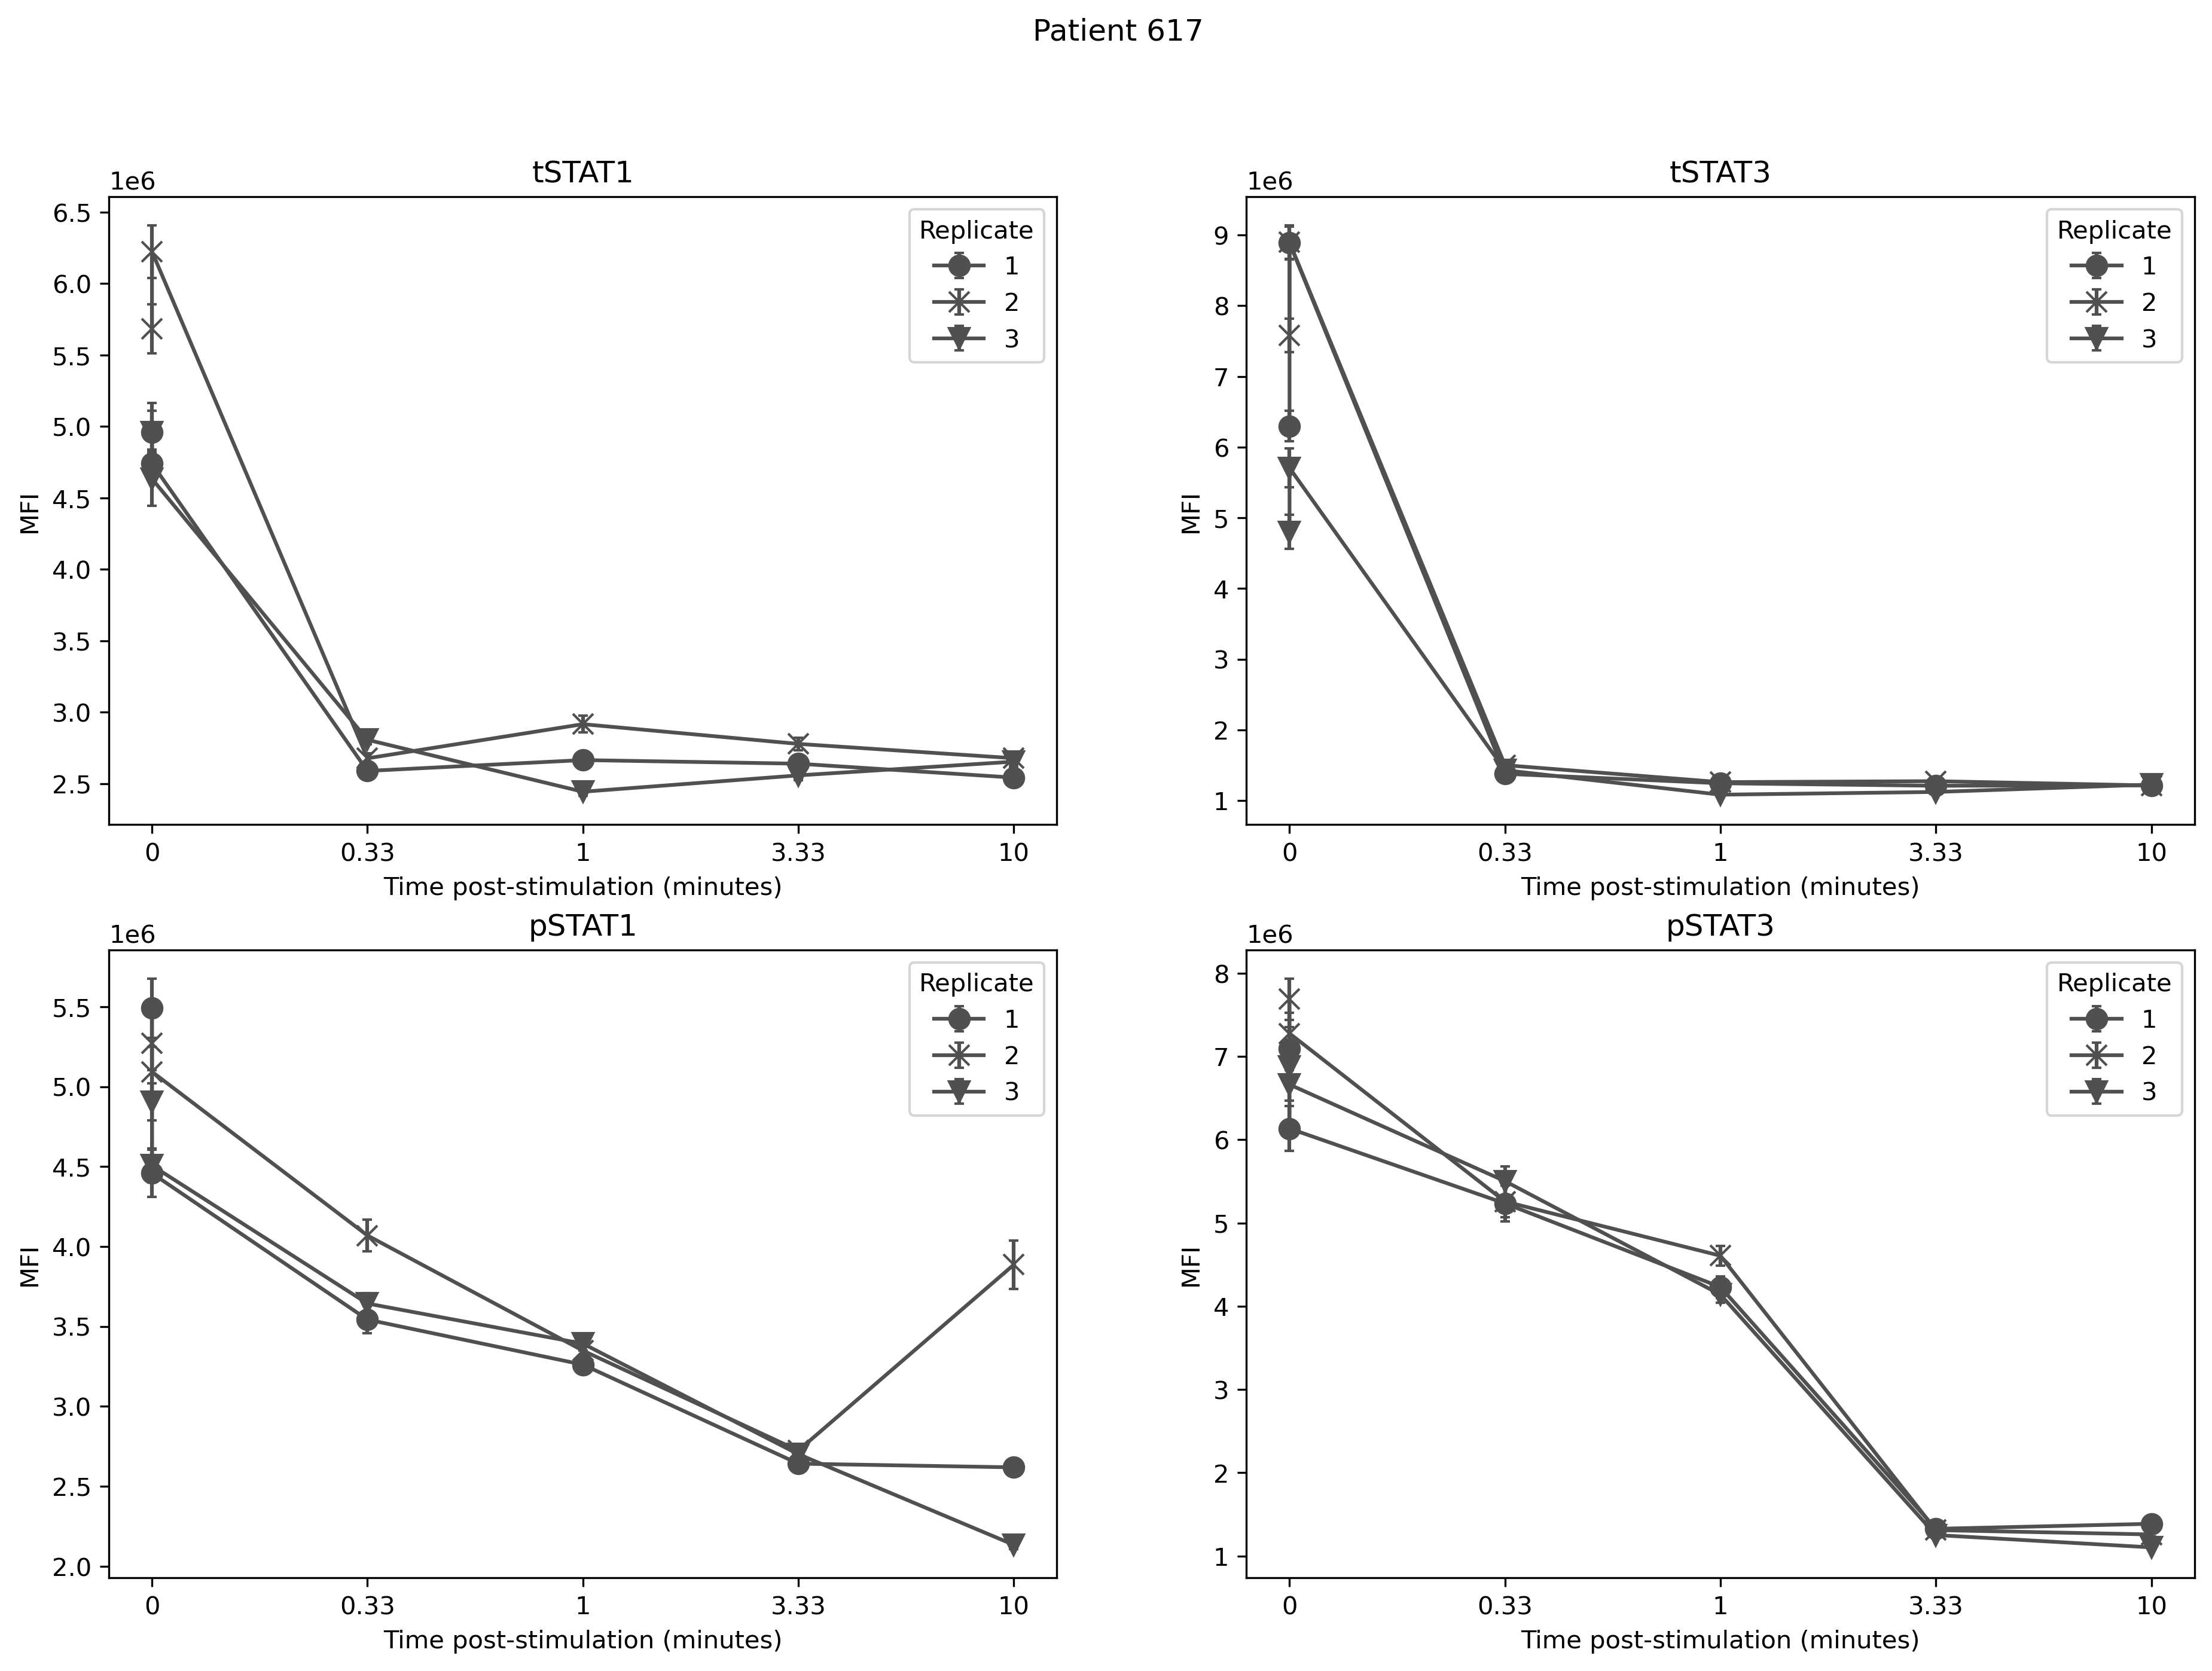

In [4]:
manual_ylim = False

og_df = dfs[0]
dose_to_ls = {
	"10 ng/mL": "-",
	"1 ng/mL": "dotted"
}

dose_to_color = {
	"1 ng/mL": "r",
	"10 ng/mL":"b"
}

il6_to_marker = {
	"1 ng/mL": "d",
	"10 ng/mL": "x"
}

replicate_to_marker = {
	1:"o",
	2:"x",
	3:"v"
}

ms = 8 # markersize
color = "#505050"
fig1, axs1 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig2, axs2 = plt.subplots(2,2, figsize=(15,10), dpi=300)
fig3, axs3 = plt.subplots(2,2, figsize=(15,10), dpi=300)

# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Fedra")]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[0][0]
	stat3_ax = cur_axs[0][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("tSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("tSTAT3")
	if manual_ylim:
		stat1_ax.set_ylim(*ylims[0][0])
		stat3_ax.set_ylim(*ylims[0][1])


# Select pSTAT measurement
df = og_df[og_df["STAT"] == "Filgo"]

for pat, cur_axs in zip(df["PatientId"].unique(), [axs1, axs2, axs3]):
	# Plot tSTATs from first scan
	stat1_ax = cur_axs[1][0]
	stat3_ax = cur_axs[1][1]
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"] == rep)]
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=replicate_to_marker[rep], ms=ms, color=color,
					ls="-", label=f"{rep}", capsize=2)
	stat1_ax.set_ylabel("MFI")
	stat1_ax.set_xlabel("Time post-stimulation (minutes)")
	stat1_ax.legend(title="Replicate")
	stat1_ax.set_title("pSTAT1")
	stat3_ax.set_ylabel("MFI")
	stat3_ax.set_xlabel("Time post-stimulation (minutes)")
	stat3_ax.legend(title="Replicate")
	stat3_ax.set_title("pSTAT3")
	if manual_ylim:
		stat1_ax.set_ylim(*ylims[1][0])
		stat3_ax.set_ylim(*ylims[1][1])

id1 = df["PatientId"].unique()[0]
id2 = df["PatientId"].unique()[1]
id3 = df["PatientId"].unique()[2]

fig1.suptitle(f"Patient {id1}")
fig2.suptitle(f"Patient {id2}");
fig3.suptitle(f"Patient {id3}")


Text(0.5, 0.98, 'IFNB Stimulation (10 ng/mL) with Donor 617')

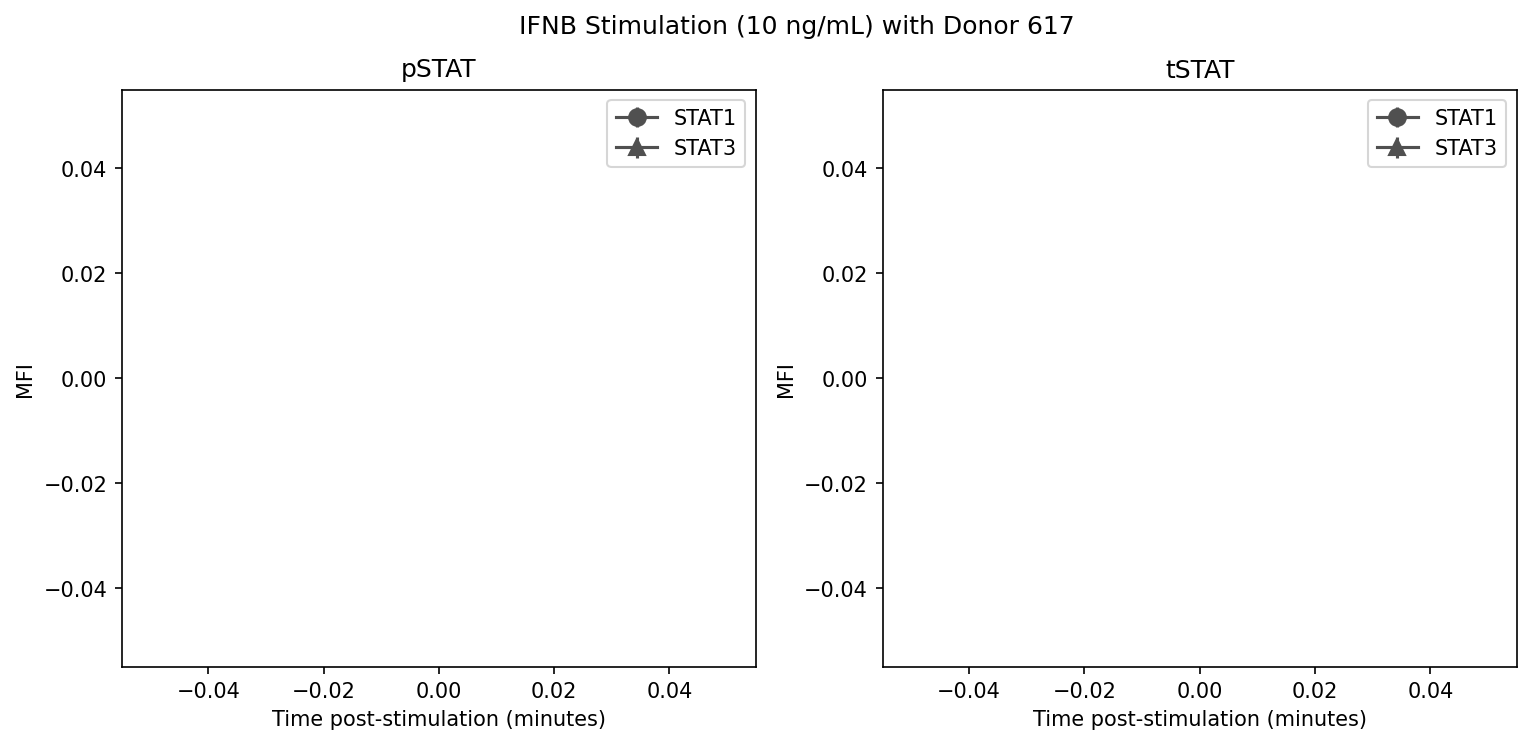

In [5]:
ms = 8 # markersize
color = "#505050"

stat_df = og_df.loc[(og_df["PatientId"] == 6170)]


# Select pSTAT measurement
pdf = stat_df[stat_df["STAT"] == "pSTAT"]
tdf = stat_df[stat_df["STAT"] == "tSTAT"]

# Dropping the last well (due to exp error)
tdf = tdf[tdf["Time"] != "90"]

fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)

axs[0].errorbar(x=pdf["Time"], y=pdf["STAT1 Mean"], yerr=pdf["STAT1 SEM"],
					marker="o", ms=ms, color=color,
					ls="-", label=f"STAT1", capsize=2)
		
axs[0].errorbar(x=pdf["Time"], y=pdf["STAT3 Mean"], yerr=pdf["STAT3 SEM"],
					marker="^", ms=ms, color=color,
					ls="-", label=f"STAT3", capsize=2)

axs[0].set_ylabel("MFI")
axs[0].set_xlabel("Time post-stimulation (minutes)")
axs[0].legend()
axs[0].set_title("pSTAT")

axs[1].errorbar(x=tdf["Time"], y=tdf["STAT1 Mean"], yerr=tdf["STAT1 SEM"],
					marker="o", ms=ms, color=color,
					ls="-", label=f"STAT1", capsize=2)
		
axs[1].errorbar(x=tdf["Time"], y=tdf["STAT3 Mean"], yerr=tdf["STAT3 SEM"],
					marker="^", ms=ms, color=color,
					ls="-", label=f"STAT3", capsize=2)

axs[1].set_ylabel("MFI")
axs[1].set_xlabel("Time post-stimulation (minutes)")
axs[1].legend()
axs[1].set_title("tSTAT")

plt.suptitle("IFNB Stimulation (10 ng/mL) with Donor 617")

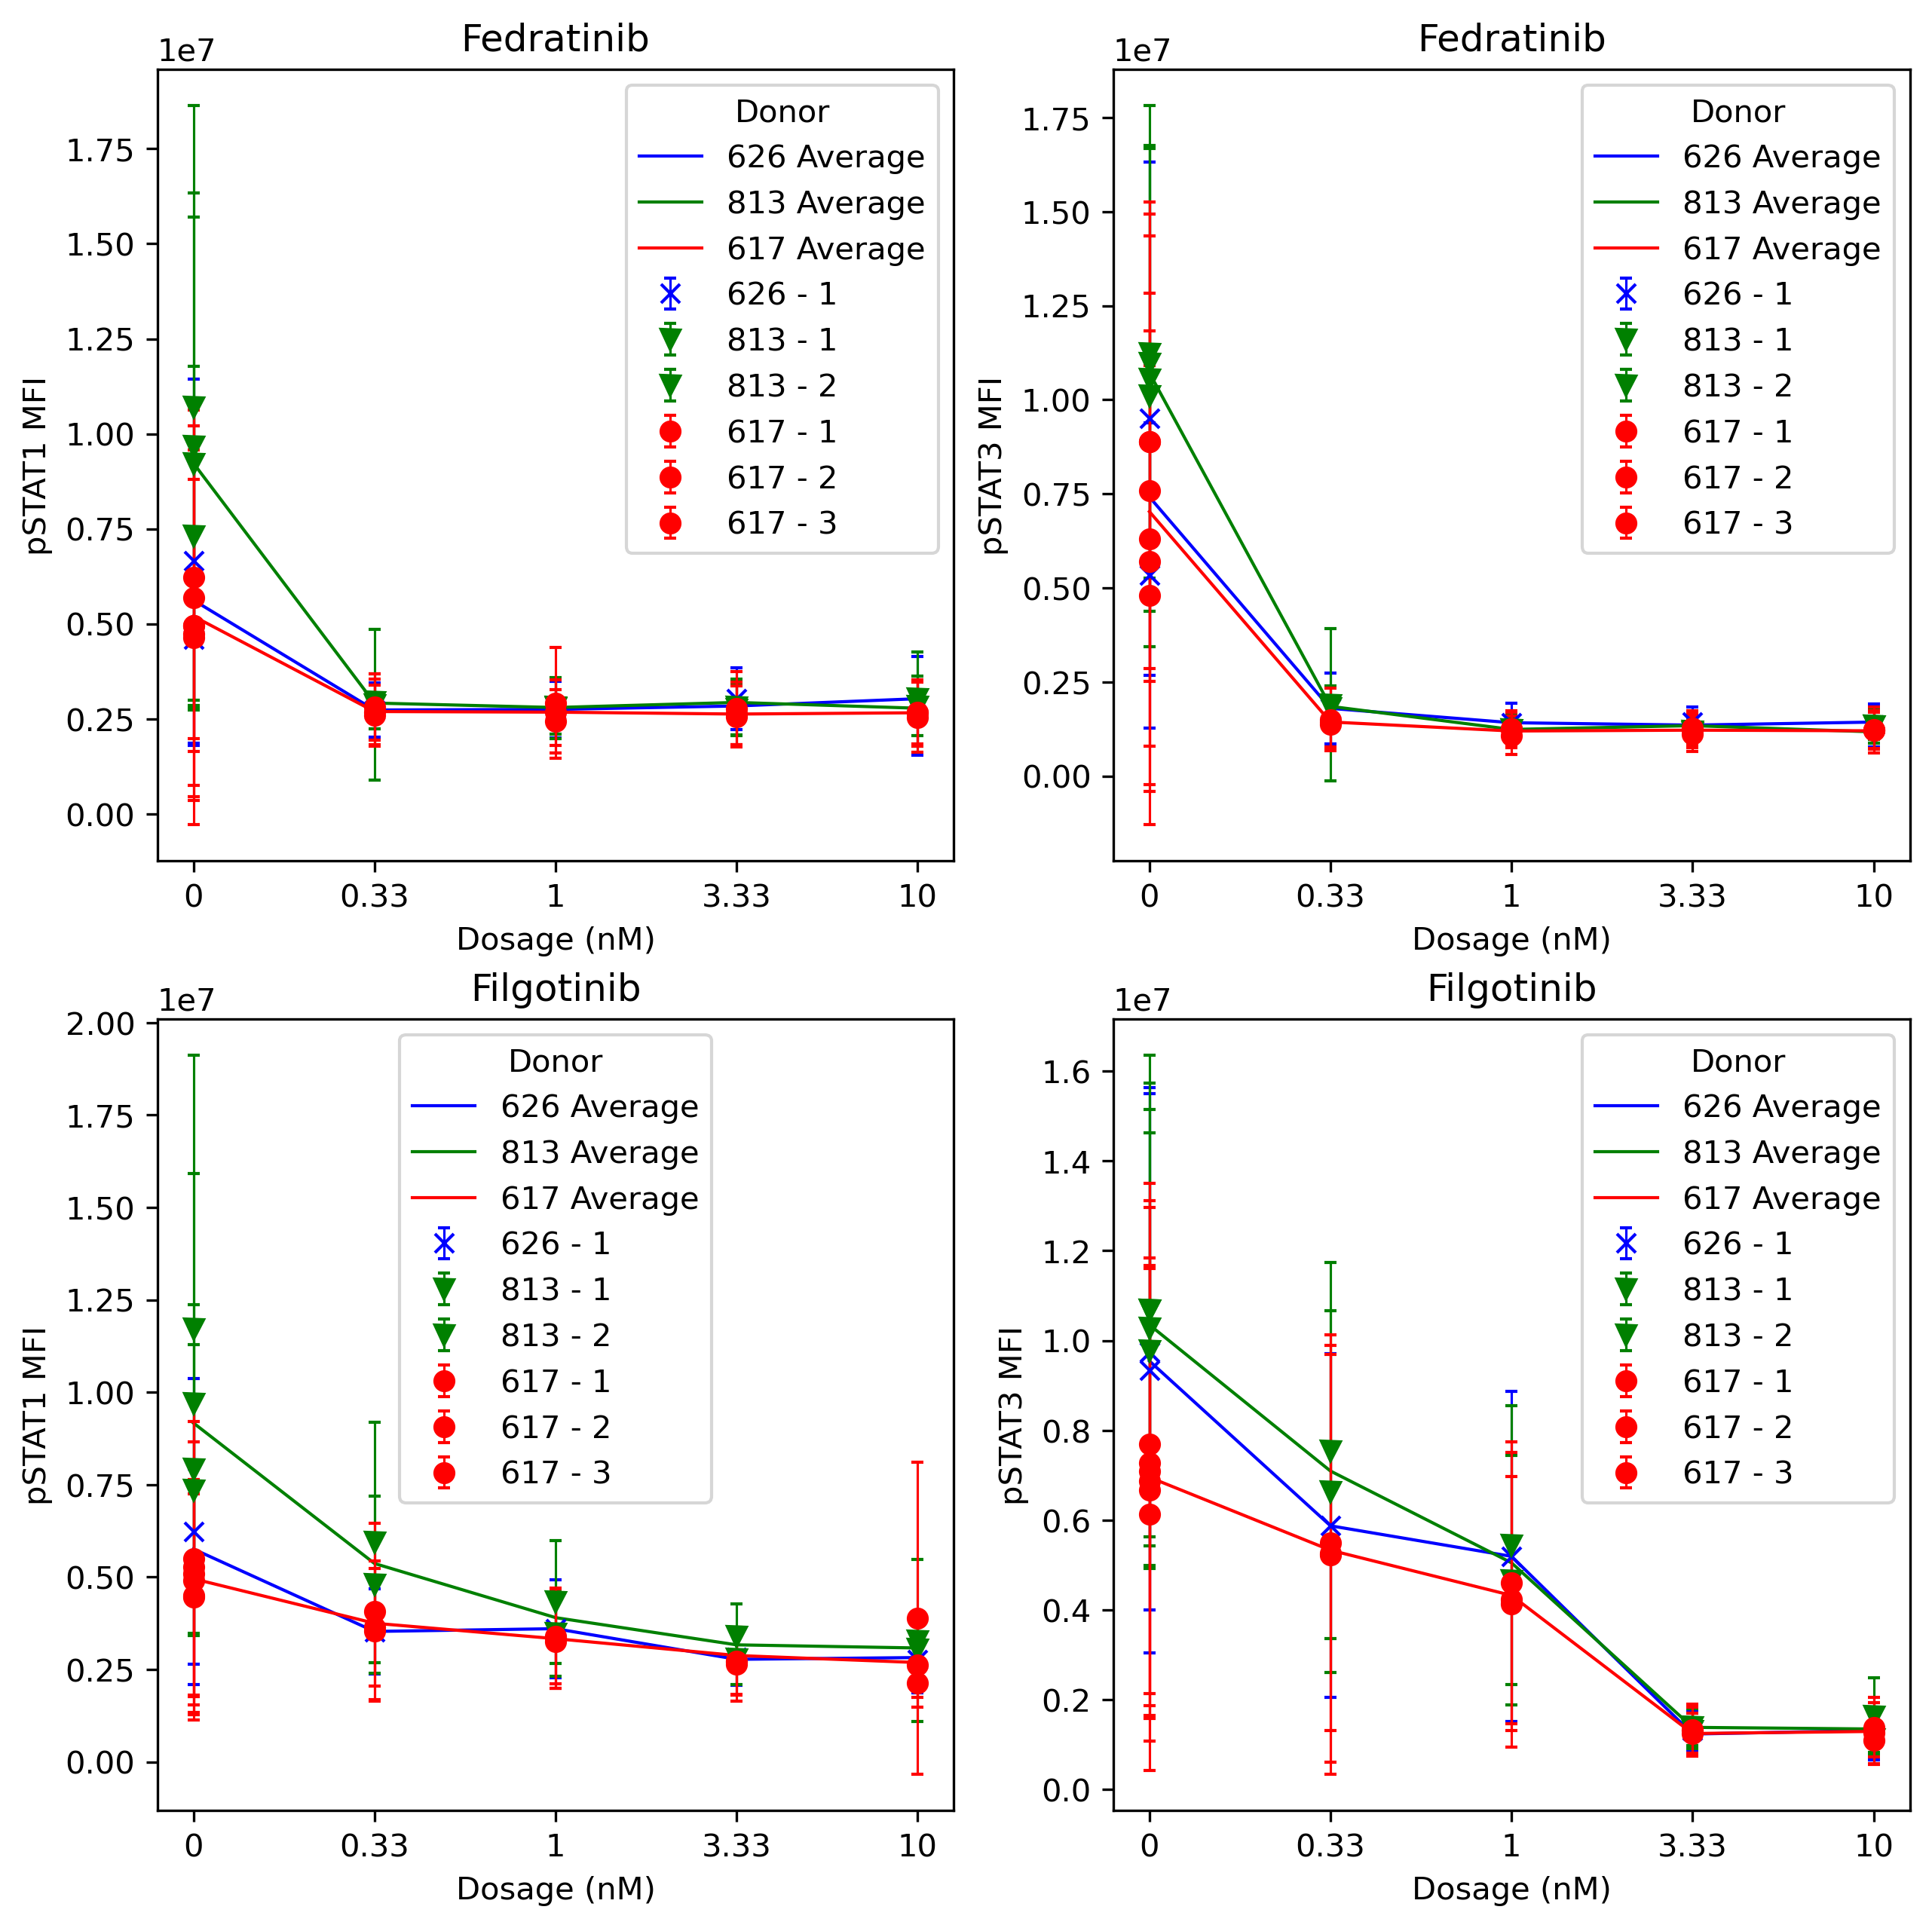

In [39]:
og_df = dfs[0]


patient_to_color = {
	617: "r",
	626: "b",
    813: "g"
}


patient_to_marker = {
	617:"o",
	626:"x",
	813:"v"
}

ms = 6 # markersize
fig1, axs = plt.subplots(2,2, figsize=(10,10), dpi=300)

# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Fedra")]

for pat in df["PatientId"].unique():
	# Plot tSTATs from first scan
	stat1_ax = axs[0][0]
	stat3_ax = axs[0][1]
 
	cur_df = df.loc[df["PatientId"] == pat]

	stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")

	stat3_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT3 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none",
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75,  label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Dosage (nM)")
	stat1_ax.legend(title="Donor")
	stat1_ax.set_title("Fedratinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Dosage (nM)")
	stat3_ax.legend(title="Donor")
	stat3_ax.set_title("Fedratinib")
 
# Select tSTAT measurement
df = og_df[(og_df["STAT"] == "Filgo")]

for pat in df["PatientId"].unique():
	# Plot tSTATs from first scan
	stat1_ax = axs[1][0]
	stat3_ax = axs[1][1]

	cur_df = df.loc[df["PatientId"] == pat]

	stat1_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT1 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")

	stat3_ax.plot(cur_df["Time"].unique(), cur_df.groupby("Time")["STAT3 Mean"].mean(),
					marker="none", color=patient_to_color[pat], 
     				lw=1, label=f"{pat} Average")
 
	#for il6 in df["IL-6 Concentration"].unique():
	for rep in df["Replicate"].unique():
		select_df = df.loc[(df["PatientId"] == pat) & (df["Replicate"]== rep)]
		if select_df.empty:
			continue
		stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
		
		stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 SEM"],
					marker=patient_to_marker[pat], ms=ms, color=patient_to_color[pat],
					ls="none", 
     				lw=0.75, label=f"{pat} - {rep}", capsize=2)
	stat1_ax.set_ylabel("pSTAT1 MFI")
	stat1_ax.set_xlabel("Dosage (nM)")
	stat1_ax.legend(title="Donor")
	stat1_ax.set_title("Filgotinib")
	stat3_ax.set_ylabel("pSTAT3 MFI")
	stat3_ax.set_xlabel("Dosage (nM)")
	stat3_ax.legend(title="Donor")
	stat3_ax.set_title("Filgotinib")
